In [168]:
# =========================================
# AirBnB NYC: LightGBM (traditional) + sklearn MLP (deep)
# CV in log-space + original price metrics
# =========================================

import numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor as SKMLP

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [170]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\data\airbnb_listings_nyc.csv")  
import io

def info_text(df):
    buf = io.StringIO()
    df.info(buf=buf)
    return buf.getvalue()

print("=== Airbnb df.info() ===")
print(info_text(df))

=== Airbnb df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_re

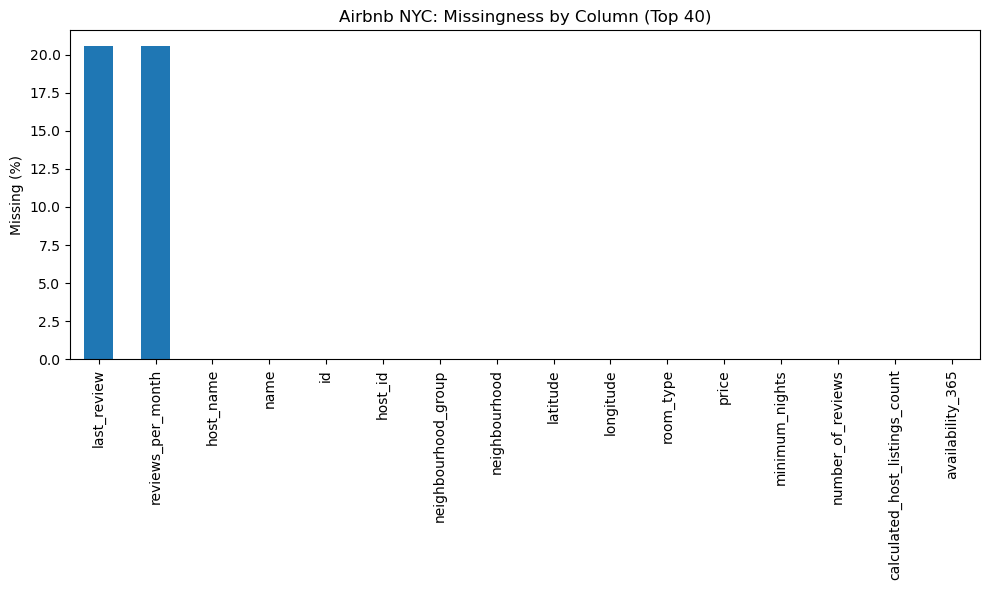

In [171]:
import matplotlib.pyplot as plt

def plot_missing_bar(df, title, savepath=None, top_n=40):
    # Compute % missing
    miss_pct = df.isna().mean().sort_values(ascending=False) * 100
    # Keep top_n longest bars 
    miss_pct = miss_pct.head(top_n)
    
    plt.figure(figsize=(10, 6))
    miss_pct.plot(kind="bar")
    plt.ylabel("Missing (%)")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

# Airbnb bar
plot_missing_bar(df, "Airbnb NYC: Missingness by Column (Top 40)", 
                 savepath="airbnb_missing_bar.png")


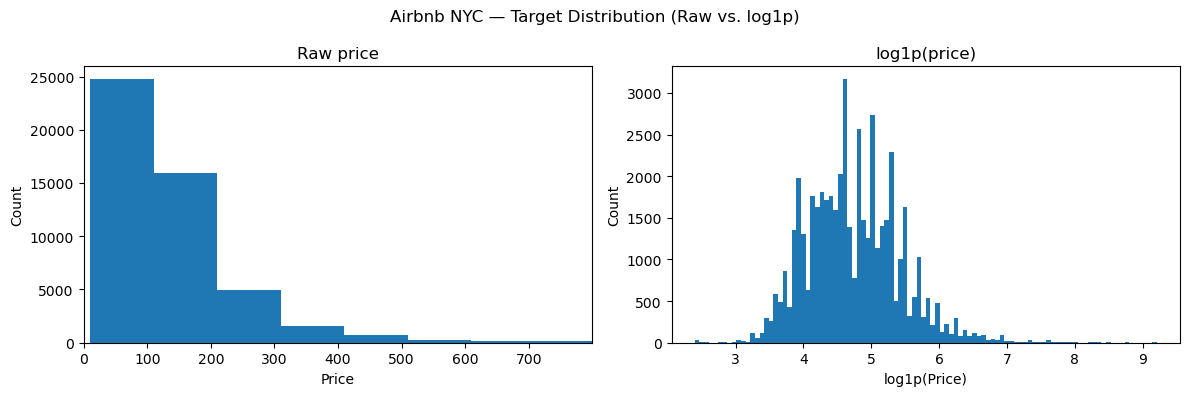

In [172]:
# =============== Load ===============
target = "price"
y_raw = df[target].clip(lower=10)      # guard against zeros/negatives if any
y = np.log1p(y_raw)                    # log-transform for stability
X = df.drop(columns=[target])

# ----- Target Distribution (raw vs. log1p) -----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw price (clip x-axis at 99th percentile so the long tail doesn't squash the histogram)
axes[0].hist(y_raw, bins=100)
axes[0].set_title("Raw price")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, float(np.percentile(y_raw, 99)))  # improves visibility

# Log1p(price)
axes[1].hist(y, bins=100)
axes[1].set_title("log1p(price)")
axes[1].set_xlabel("log1p(Price)")
axes[1].set_ylabel("Count")

fig.suptitle("Airbnb NYC — Target Distribution (Raw vs. log1p)")
fig.tight_layout()
plt.show()

# Identify columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

# =============== Robust stratification labels for regression ===============
def make_strata(y_cont, n_splits=5, max_bins=10):
    """Return labels suitable for StratifiedKFold by binning a continuous y.
       Decrease the number of bins until every bin has >= n_splits samples."""
    bins = max_bins
    y = pd.Series(y_cont).reset_index(drop=True)
    while bins >= n_splits:
        cats = pd.qcut(y, q=bins, duplicates="drop")
        # Convert to strings so scikit treats it as multiclass, not 'unknown'
        labels = cats.astype(str)
        counts = labels.value_counts()
        if (counts >= n_splits).all():
            return labels.values
        bins -= 1
    # Fallback: all one label (equivalent to plain KFold)
    return np.zeros(len(y), dtype=int)

n_splits = 5
y_strata = make_strata(y, n_splits=n_splits, max_bins=10)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
cv_folds = list(skf.split(X, y_strata))

In [173]:
# =============== Preprocessing ===============
# For MLP (deep): impute + scale numeric; impute + OHE categoricals
prep_mlp = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", RobustScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=10))]), cat_cols)
])

# For LightGBM: impute + OHE (no scaling)
prep_lgbm = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10), cat_cols)
])


In [174]:
# =============== Models ===============
# (A) Traditional: LightGBM
lgbm = Pipeline([
    ("prep", prep_lgbm),
    ("model", LGBMRegressor(
        objective="huber",
        n_estimators=1000, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        max_depth=-1, random_state=RANDOM_STATE
    ))
])

# (B) “Deep”: sklearn MLP (neural net) 
mlp = Pipeline([
    ("prep", prep_mlp),
    ("model", SKMLP(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,                # L2
        batch_size=512,
        learning_rate_init=1e-3,
        max_iter=250,
        early_stopping=True,
        n_iter_no_change=12,
        random_state=RANDOM_STATE,
        verbose=False
    ))
])

In [175]:
# =============== Metrics ===============
def rmse(yt, yp): 
    return np.sqrt(mean_squared_error(yt, yp))

def mae_real(yt_log, yp_log):
    yt, yp = np.expm1(yt_log), np.expm1(yp_log)
    return mean_absolute_error(yt, yp)

def rmse_real(yt_log, yp_log):
    yt, yp = np.expm1(yt_log), np.expm1(yp_log)
    return np.sqrt(mean_squared_error(yt, yp))

from sklearn.metrics import mean_squared_error  

scoring = {
    # log-price space (training target)
    "MAE_log": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE_log": make_scorer(lambda yt, yp: rmse(yt, yp), greater_is_better=False),
    "R2_log": make_scorer(r2_score),
    # original price space (business units)
    "MAE_real": make_scorer(mae_real, greater_is_better=False),
    "RMSE_real": make_scorer(rmse_real, greater_is_better=False),
}

In [176]:
# =============== Evaluate helper ===============
def summarize_cv(res, name):
    print(f"\n{name}:")
    for key in sorted(res.keys()):
        if key.startswith("test_"):
            arr = res[key]
            # Flip sign for error metrics built with greater_is_better=False
            if any(m in key for m in ["MAE", "RMSE"]):
                arr = -arr
            print(f"  {key[5:]:<10} {arr.mean():.4f} ± {arr.std():.4f}")

def evaluate(pipe, name):
    res = cross_validate(pipe, X, y, cv=cv_folds, scoring=scoring, n_jobs=-1, return_estimator=False)
    summarize_cv(res, name)


[FAST Search] LightGBM on 25% subset, 3-fold (stratified by binned log-price) ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 12220, number of used features: 261
[LightGBM] [Info] Start training from score 4.736231

[Best Params - fast]: {'model__subsample': 0.9, 'model__num_leaves': 63, 'model__n_estimators': 400, 'model__min_child_samples': 20, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.9}
[Best CV log-MAE - fast] 0.3184

[Final Eval] LightGBM (fast-searched params) on full 5-fold ...

LightGBM (fast-searched params):
  MAE_log    0.3006 ± 0.0017
  MAE_real   55.1394 ± 1.0483
  R2_log     0.6244 ± 0.0045
  RMSE_log   0.4244 ± 0.0035
  RMS

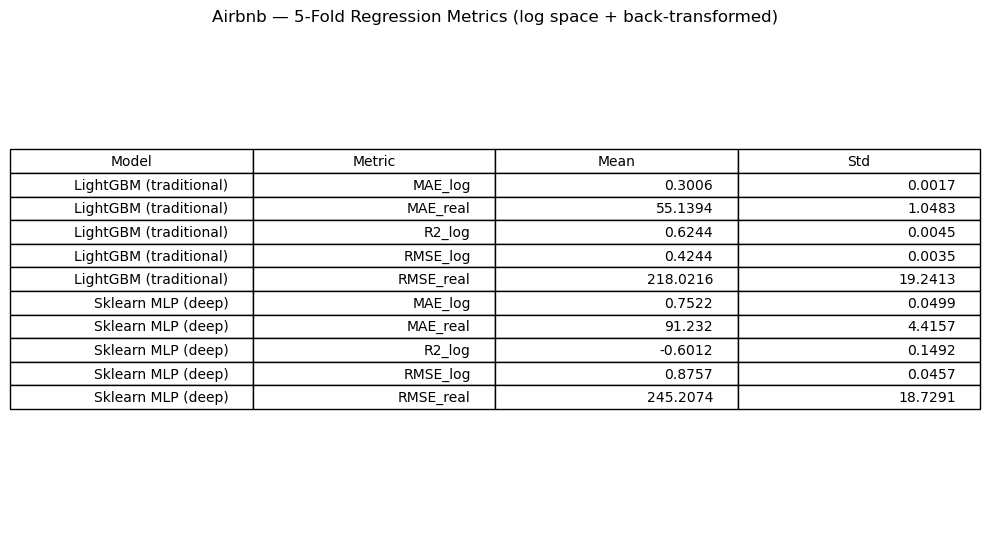


LightGBM (traditional):
  MAE_log    0.3006 ± 0.0017
  MAE_real   55.1394 ± 1.0483
  R2_log     0.6244 ± 0.0045
  RMSE_log   0.4244 ± 0.0035
  RMSE_real  218.0216 ± 19.2413

Sklearn MLP (deep learning):
  MAE_log    0.7522 ± 0.0499
  MAE_real   91.2320 ± 4.4157
  R2_log     -0.6012 ± 0.1492
  RMSE_log   0.8757 ± 0.0457
  RMSE_real  245.2074 ± 18.7291


In [188]:
# ----- (Regression): LGBM best params & CV trace -----
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

def stratified_subsample(X, y, strata, frac=0.25, seed=42):
    rng = np.random.RandomState(seed)
    idx_keep = []
    strata = pd.Series(strata)
    for _, idx in strata.groupby(strata).groups.items():
        k = max(1, int(len(idx) * frac))
        idx_keep.extend(rng.choice(list(idx), size=k, replace=False))
    idx_keep = np.array(sorted(idx_keep))
    return X.iloc[idx_keep].reset_index(drop=True), y[idx_keep], strata.iloc[idx_keep].values

# Subsample (y_strata)
X_search, y_search, strata_search = stratified_subsample(X, y, y_strata, frac=0.25, seed=RANDOM_STATE)

# Build CV **splits** stratifying by the binned labels, not the continuous y
skf_search = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_search_splits = list(skf_search.split(X_search, strata_search))

#Trimmed search space + fewer candidates
param_dist_lgbm_fast = {
    "model__n_estimators": [400, 700, 1000],
    "model__num_leaves": [31, 63, 127],
    "model__min_child_samples": [20, 50, 100],
    "model__subsample": [0.7, 0.9],
    "model__colsample_bytree": [0.7, 0.9],
    "model__learning_rate": [0.05, 0.08]
}

search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist_lgbm_fast,
    n_iter=10,
    cv=cv_search_splits,                     # pass the precomputed splits
    scoring="neg_mean_absolute_error",       # log-MAE (target is log1p(price))
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
    return_train_score=False
)

print("\n[FAST Search] LightGBM on 25% subset, 3-fold (stratified by binned log-price) ...")
search_lgbm.fit(X_search, y_search)

print("\n[Best Params - fast]:", search_lgbm.best_params_)
print(f"[Best CV log-MAE - fast] {-search_lgbm.best_score_:.4f}")

cv_df = pd.DataFrame(search_lgbm.cv_results_).sort_values("rank_test_score")

# 4) Refit with best params and evaluate on full 5-fold CV
best_params = search_lgbm.best_params_
lgbm_final = lgbm.set_params(**best_params)
print("\n[Final Eval] LightGBM (fast-searched params) on full 5-fold ...")
evaluate(lgbm_final, "LightGBM (fast-searched params)")

def cv_metrics_df(pipe, name):
    res = cross_validate(pipe, X, y, cv=cv_folds, scoring=scoring, n_jobs=-1, return_estimator=False)
    rows = []
    for key in sorted(res.keys()):
        if not key.startswith("test_"):
            continue
        arr = np.array(res[key])
        # Flip sign for error scorers
        if any(m in key for m in ["MAE", "RMSE"]):
            arr = -arr
        metric = key.replace("test_", "")
        rows.append((metric, arr.mean(), arr.std()))
    dfm = pd.DataFrame(rows, columns=["Metric", "Mean", "Std"]).set_index("Metric")
    dfm["Model"] = name
    return dfm

df_lgbm = cv_metrics_df(lgbm, "LightGBM (traditional)")
df_mlp  = cv_metrics_df(mlp,  "Sklearn MLP (deep)")


# Render as a matplotlib table (image)
fig, ax = plt.subplots(figsize=(10, 2 + 0.35*len(df_e1)))
ax.axis("off")
tbl = ax.table(cellText=df_e1.round(4).values,
               colLabels=df_e1.columns.tolist(),
               loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.2)
plt.title("Airbnb — 5-Fold Regression Metrics (log space + back-transformed)")
plt.tight_layout()
plt.show()

# =============== Run both models ===============
evaluate(lgbm, "LightGBM (traditional)")
evaluate(mlp,  "Sklearn MLP (deep learning)")

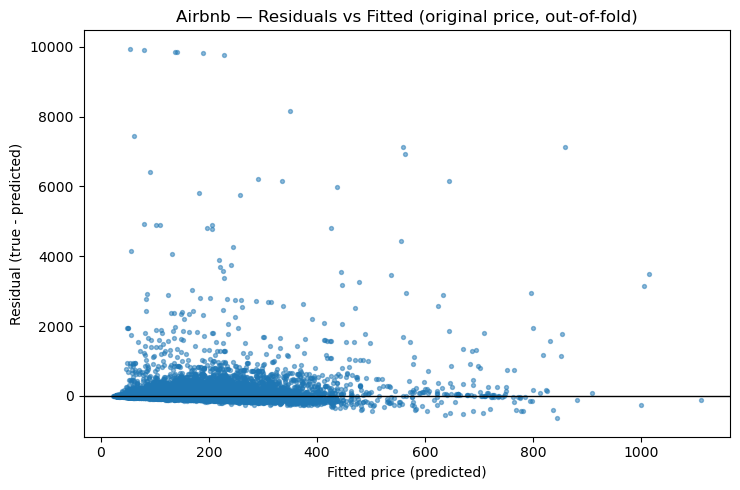

In [194]:
from sklearn.model_selection import cross_val_predict

model_for_residuals = lgbm  

# Out-of-fold predictions on LOG space
yhat_log_oof = cross_val_predict(model_for_residuals, X, y, cv=cv_folds, n_jobs=-1, method="predict")

# Back-transform to original price
y_true_price = np.expm1(y)           # from log1p back to price
y_pred_price = np.expm1(yhat_log_oof)

residuals = y_true_price - y_pred_price

# Basic residuals vs fitted plot
plt.figure(figsize=(7.5, 5))
plt.scatter(y_pred_price, residuals, s=8, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Fitted price (predicted)")
plt.ylabel("Residual (true - predicted)")
plt.title("Airbnb — Residuals vs Fitted (original price, out-of-fold)")
plt.tight_layout()
plt.show()